# Übung 7: Vierecke zählen

Die Übungsaufgabe in dieser Woche ist von einer Aufgabe der [langen Nacht der Mathematik](https://mathenacht.de) inspiriert. Bei der Originalaufgabe ging es darum, die Anzahl der [Kongruenzklassen](https://de.wikipedia.org/wiki/Kongruenzabbildung) von Vierecken mit Flächeninhalt 1 auf einem Geobrett mit 4 x 4 Punkten 
![Geobrett](http://www.rittel-verlag.de/WebRoot/Store20/Shops/62618028/4C12/45CA/D328/2D5D/3895/C0A8/29B9/6EFD/Geobrett-4x4-Holz-01_m.jpg) zu zählen.

Die Einheiten sind dabei so normiert, dass die Fläche des kleinsten Quadrates auf dem Geobrett den Inhalt 1 hat.

## Flächeninhalt von Polygonen mit ganzzahligen Koordinaten

Der Flächeninhalt von Polygonen auf einem solchen Geobrett lässt sich sehr einfach über den [Satz von Pick](https://de.wikipedia.org/wiki/Satz_von_Pick) berechnen, indem man die Zahl $i$ der Gitterpunkte im Inneren (rote Punkte) und die Zahl $b$ der Punkte auf dem Rand des Polygons (grüne Punkte) zählt:
![Bild: Satz von Pick](https://upload.wikimedia.org/wikipedia/commons/f/f1/Pick-theorem.png)

Für den Flächeninhalt gilt dann
$$
A = i + \frac{b}{2} -1.
$$

Daraus ergibt sich unmittelbar, dass die gesuchten Vierecke **keine inneren Punkte** besitzen und außer den vier Ecken **keine weiteren Punkte des Gitters auf dem Rand liegen** dürfen.

In [202]:
import math
from itertools import product

            
class Vector(tuple):
    
    def __new__(cls, *coords): 
        if len(coords) != 2: 
            raise ValueError("Dimension must be 2")
        return tuple.__new__(cls, coords)
        
    def __add__(self, q):
        return Vector(self[0] + q[0], self[1] + q[1])
    
    def __sub__(self, q):
        return Vector(self[0] - q[0], self[1] - q[1])
    
    def __mul__(self, q):
        """Berechne das Skalarprodukt"""
        return self[0] * q[0] + self[1] * q[1]
    
    def normal(self):
        """Berechne den Normalenvektor"""
        return Vector(self[1], -self[0])    
    
    def len2(self):
        """Berechne das Quadrat der Länge des Vektors"""
        return self[0]*self[0] + self[1]*self[1]
            
            
def intersect(p, q, r, s):
    """Prüfe, ob die Strecken pq und rs sich schneiden.
    
    Dazu prüfen wir, ob die Punkte einer Strecke im selben Halbraum bezogen auf die Gerade durch 
    die andere Strecke liegen."""
    n1 = (q-p).normal()
    n2 = (s-r).normal()
    if (n1*(r-q)) * (n1*(s-q)) >= 0 or (n2*(p-r)) * (n2*(q-r)) >= 0:
        return False
    else:
        return True
            
class Quadrilateral(tuple):
    
    def __new__(cls, points):
        """Erzeuge ein normalisiertes Viereck aus den übergebenen Punkten.
        Falls die Punkte kein gültiges Viereck ergeben, gebe None zurück."""

        # Prüfe, ob wir vier verschiedene Punkte haben
        if len(set(points)) != 4:
            return None
        
        # Prüfe, dass zwei aufeinanderfolgende Seiten nicht kolinear sind
        for i in range(4):
            j = (i + 1) % 4
            k = (i + 2) % 4
            if (points[j] - points[i]) * (points[k] - points[j]).normal() == 0:
                return None
            
        # Prüfe, dass die gegenüberliegenden Seiten sich nicht schneiden
        if intersect(points[0], points[1], points[2], points[3]) or \
           intersect(points[1], points[2], points[3], points[0]):
            return None
        
        # Bei konkaven Vierecken liegt nur eine Diagonale innerhalb des Vierecks
        # Wir fordern, das die Diagonale p0p2 im Inneren liegt (das macht die Prüfung der Kongruenz einfacher).
        # Dazu müssen p1 und p3 in verschiedenen Halbräumen liegen
        n = (points[2]-points[0]).normal()
        if (n*(points[1]-points[0])) * (n*(points[3]-points[0])) > 0:
            return None
        
        # Falls beide Diagonalen im inneren liegen, soll p0p2 länger als p1p3 sein
        n = (points[3]-points[1]).normal()
        if (n*(points[2]-points[1])) * (n*(points[0]-points[1])) <= 0:
            if (points[3]-points[1]).len2() > (points[2]-points[0]).len2():
                return None
        
        # Als letztes forden wir noch, dass die Punkte "positiv orientiert" sind
        if (points[1]-points[0]).normal() * (points[2]-points[1]) < 0:
            return None
    
        return super().__new__(cls, points)

    def __init__(self, points):
        self.points = points
        tri1 = frozenset(((points[1]-points[0]).len2(), (points[2]-points[1]).len2(), (points[2]-points[0]).len2()))
        tri2 = frozenset(((points[3]-points[0]).len2(), (points[2]-points[3]).len2(), (points[2]-points[0]).len2()))
        self.triangles = frozenset((tri1, tri2))
        self.d1 = (points[2] - points[0]).len2()
        self.d2 = (points[3] - points[1]).len2()
        self.n1 = (((points[1]-points[0]).normal(), points[0]), 
                   ((points[2]-points[1]).normal(), points[1]),
                   ((points[0]-points[2]).normal(), points[2]))
        self.n2 = (((points[0]-points[3]).normal(), points[3]), 
                   ((points[3]-points[2]).normal(), points[2]),
                   ((points[2]-points[0]).normal(), points[0]))
    
    def __eq__(self, other):
        """Wir betrachten zwei Vierecke als gleich, wenn sie kongruent sind.
        Zwei Vierecke sind kongruent, wenn sie aus kongruenten Dreiecken bestehen und die 
        Diagonalen gleich sind."""
        return self.triangles == other.triangles and self.d1 == other.d1 and self.d2 == other.d2
    
    def __hash__(self):
        return (self.triangles, self.d1, self.d2).__hash__()
    
    def is_boundary(self, p):
        """Prüfe, ob p ein Punkt auf dem Rand ist.
        Dies ist der Fall, wenn es eine Seite rs gibt, so dass rp und rs kolinear sind
        und (p - r) * (p - s) <= 0 ist."""
        for i in range(4):
            #print(f"{p} {self.points[i]} {i}")
            if p == self.points[i]:
                return True
            
            j = (i + 1) % 4
            if (p - self.points[i]) * (self.points[j] - self.points[i]).normal() != 0:
                continue
            else:
                return (p - self.points[i]) * (p - self.points[j]) <= 0
    
    def is_inner(self, p):
        """Prüfe, ob p ein innerer Punkt oder ein Randpunkt ist.
        Dies prüfen wir, indem wir testen, ob der Punkt für eines der Dreiecke 
        für alle Seiten im positiven Halbraum liegt."""
        for (n, q) in self.n1:
            #print(f"{p}: {n*(p-q)}")
            if n * (p-q) < 0:
                break
        else:
            return True
            
        for (n, q) in self.n2:
            #print(f"{p}: {n*(p-q)}")
            if n * (p-q) < 0:
                break
        else:
            return True
        
        return False
        
    def area(self):
        """Berechne den Flächeninhalt mithilfe des Satzes von Pick"""   
        inner = []
        boundary = []
        for p in (Vector(x, y) for x in range(4) for y in range(4)):
            if self.is_boundary(p):
                boundary.append(p)
                
            elif self.is_inner(p):
                inner.append(p)
    
        return len(inner) + len(boundary)/2 - 1
    
    def perimeter(self):
        """Berechne den Umfang"""
        peri = 0;
        for i in range(4):
            j = (i + 1) % 4
            peri += math.sqrt((self.points[j]-self.points[i]).len2())
        return peri



In [203]:
from collections import defaultdict

quadrilaterals = defaultdict(set)

def points():
    """Generatorfunktion für alle Punkte des Geobretts"""
    for x in range(4):
        for y in range(4):
            yield Vector(x, y)

for points in product(*(points() for i in range(4))):
                
    ql = Quadrilateral(points)
    if ql is None: continue
                    
    quadrilaterals[ql.area()].add(ql)

for k in quadrilaterals.keys():
    mp = max([ql.perimeter() for ql in quadrilaterals[k]])
    print(f"Anzahl Vierecke mit A={k}: {len(quadrilaterals[k]):2d}, max. Umfang: {mp:.2f}")

Anzahl Vierecke mit A=1.0: 15, max. Umfang: 11.68
Anzahl Vierecke mit A=1.5: 20, max. Umfang: 11.83
Anzahl Vierecke mit A=2.5: 20, max. Umfang: 10.64
Anzahl Vierecke mit A=2.0: 29, max. Umfang: 11.08
Anzahl Vierecke mit A=3.5: 11, max. Umfang: 10.02
Anzahl Vierecke mit A=3.0: 30, max. Umfang: 10.89
Anzahl Vierecke mit A=5.0:  8, max. Umfang: 9.84
Anzahl Vierecke mit A=4.5: 11, max. Umfang: 9.84
Anzahl Vierecke mit A=4.0: 16, max. Umfang: 10.02
Anzahl Vierecke mit A=5.5:  3, max. Umfang: 10.02
Anzahl Vierecke mit A=6.0:  6, max. Umfang: 10.61
Anzahl Vierecke mit A=6.5:  2, max. Umfang: 10.40
Anzahl Vierecke mit A=7.5:  1, max. Umfang: 11.16
Anzahl Vierecke mit A=9.0:  1, max. Umfang: 12.00


((0, 1), (0, 2), (1, 1), (3, 0)) 7.81


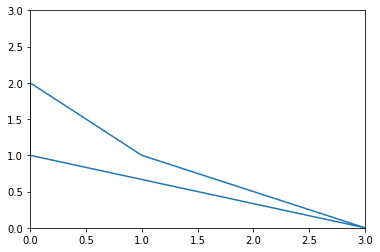

((0, 1), (2, 2), (1, 1), (2, 0)) 7.30


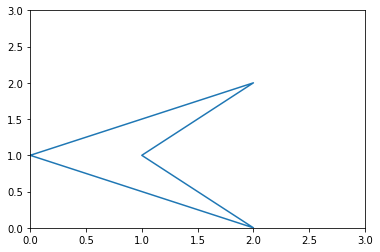

((0, 1), (3, 2), (1, 1), (3, 0)) 10.80


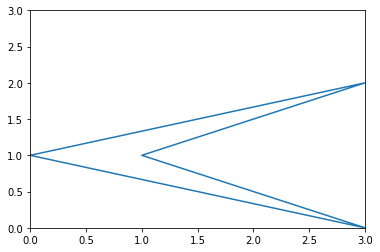

((0, 0), (0, 1), (1, 3), (1, 2)) 6.47


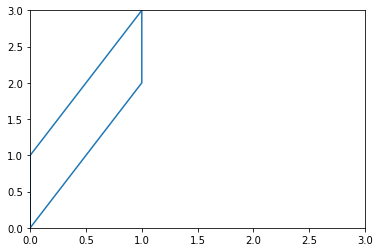

((0, 0), (0, 1), (1, 1), (3, 2)) 7.84


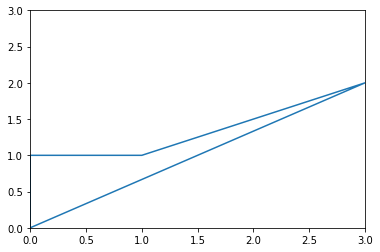

((0, 1), (2, 2), (1, 1), (3, 0)) 9.05


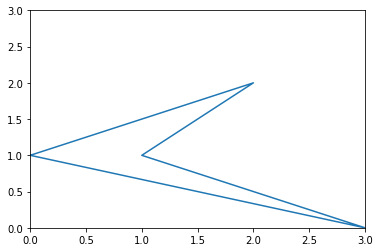

((0, 1), (1, 2), (1, 1), (2, 0)) 6.06


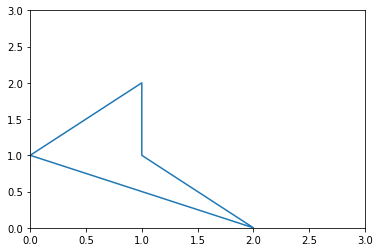

((0, 0), (1, 3), (1, 2), (2, 3)) 9.18


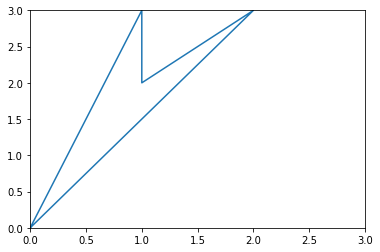

((0, 0), (1, 2), (1, 1), (2, 1)) 6.47


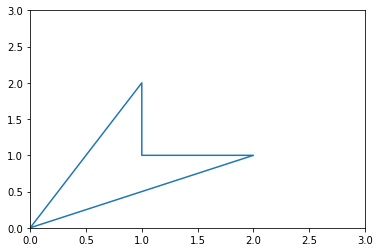

((0, 0), (1, 2), (1, 1), (3, 2)) 9.08


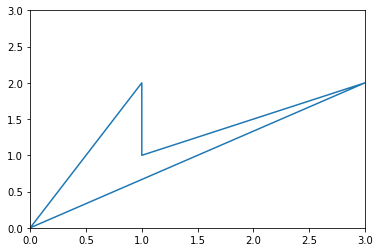

((0, 0), (0, 1), (1, 1), (1, 0)) 4.00


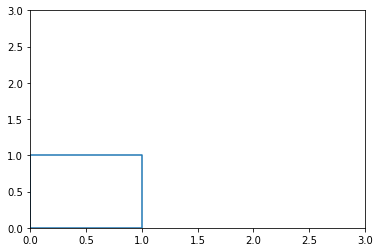

((0, 0), (1, 1), (3, 2), (2, 1)) 7.30


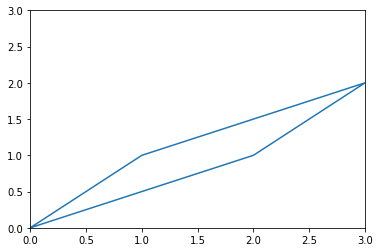

((0, 0), (2, 3), (1, 1), (3, 2)) 11.68


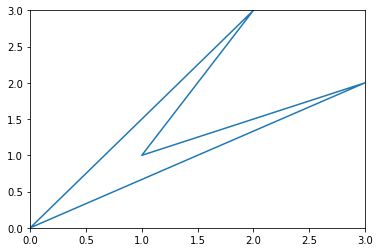

((0, 1), (1, 2), (1, 1), (3, 0)) 7.81


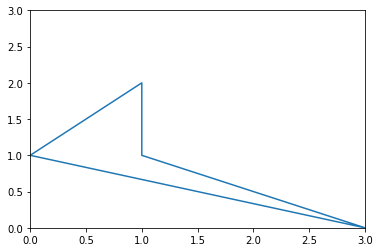

((0, 0), (0, 1), (1, 2), (1, 1)) 4.83


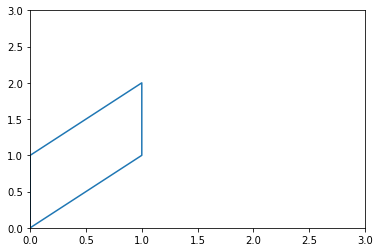

In [204]:
%matplotlib inline
import matplotlib.pyplot as plt

for ql in list(quadrilaterals[1]):
    x = []
    y = []
    for i in range(5):
        i = i % 4
        x.append(ql[i][0])
        y.append(ql[i][1])
        
    print(f"{ql} {ql.perimeter():.2f}")
    plt.plot(x, y)
    plt.axis([0, 3, 0, 3])

    plt.show()            